In [1]:
# Deep Learning
import torch
import torchvision
import torchvision.transforms as transforms

# Data management
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('train.csv')
df_y = df['diagnosis']

df.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [151]:
classes = ('0', '1', '2', '3', '4')

In [145]:
n_data = 500
y_n = lambda x: 1 if x > 0 else 0

# y to train 
y = df_y[:n_data]
# y = np.array([y_n(i) for i in y])
y = np.full((1,n_data),y)
y = torch.from_numpy(y)

# y to test
y_test = df_y[:n_data*2]
# y_test = np.array([y_n(i) for i in y_test])
y_test = np.full((1,n_data*2),y_test)
y_test = torch.from_numpy(y_test)

In [146]:
from torchvision import datasets, transforms

In [147]:
transform = transforms.Compose([transforms.Resize(32),
                                transforms.CenterCrop(32),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder('./train_images', transform=transform)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=n_data, shuffle=False, num_workers=4, \
                                          drop_last=True )

testLoader = torch.utils.data.DataLoader(dataset, batch_size=n_data*2, shuffle=False, num_workers=4, \
                                          drop_last=True )

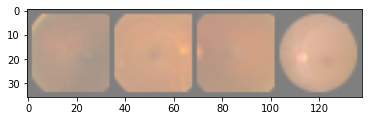

    2     4     1     0


In [152]:
# functions to show an image

showcase = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(showcase)
images, labels = dataiter.next()
labels = y[0]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [153]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [154]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [156]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = y[0]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [157]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [158]:
dataiter = iter(testLoader)
images, labels = dataiter.next()
labels = y_test[0]

In [159]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [160]:
outputs = net(images)

In [161]:
_, predicted = torch.max(outputs, 1)

In [162]:
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        labels = y_test[0]
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 46 %
